# Performance Benchmarks - CHU Data Lakehouse

**Objectif** : Mesurer les performances réelles sur requêtes métier

**Auteurs** : Nejma MOUALHI | Brieuc OLIVIERI | Nicolas TAING

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

In [2]:
# Charger les résultats de benchmark
with open('/home/jovyan/data/performance/benchmark_results.json', 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results)
df = df[df['runs'] > 0]  # Exclure requêtes non exécutées
print(f"Chargé {len(df)} requêtes de benchmark")
df

Chargé 9 requêtes de benchmark


,query,avg_time,min_time,max_time,result_count,runs
0,Q1_Count_Total,15.568,14.712,16.696,1,3
1,Q2_Consultations_By_Year,15.124,14.461,15.518,9,3
2,Q3_Top_Diagnostics,16.623,15.973,17.460,10,3
3,Q4_Consultations_By_Speciality,16.662,15.534,17.924,15,3
4,Q5_Temporal_Filter_2019,15.398,14.774,16.470,12,3
5,Q6_Hospitalisations_Stats,8.873,8.745,9.070,9,3
7,Q8_Satisfaction_By_Region,0.341,0.277,0.433,0,3
8,Q9_Multi_Dimension_Analysis,18.356,16.476,21.283,20,3
9,Q10_Hospitalisation_By_Diagnostic,10.623,10.078,11.543,10,3


## Graphique 1 : Temps d'exécution par requête

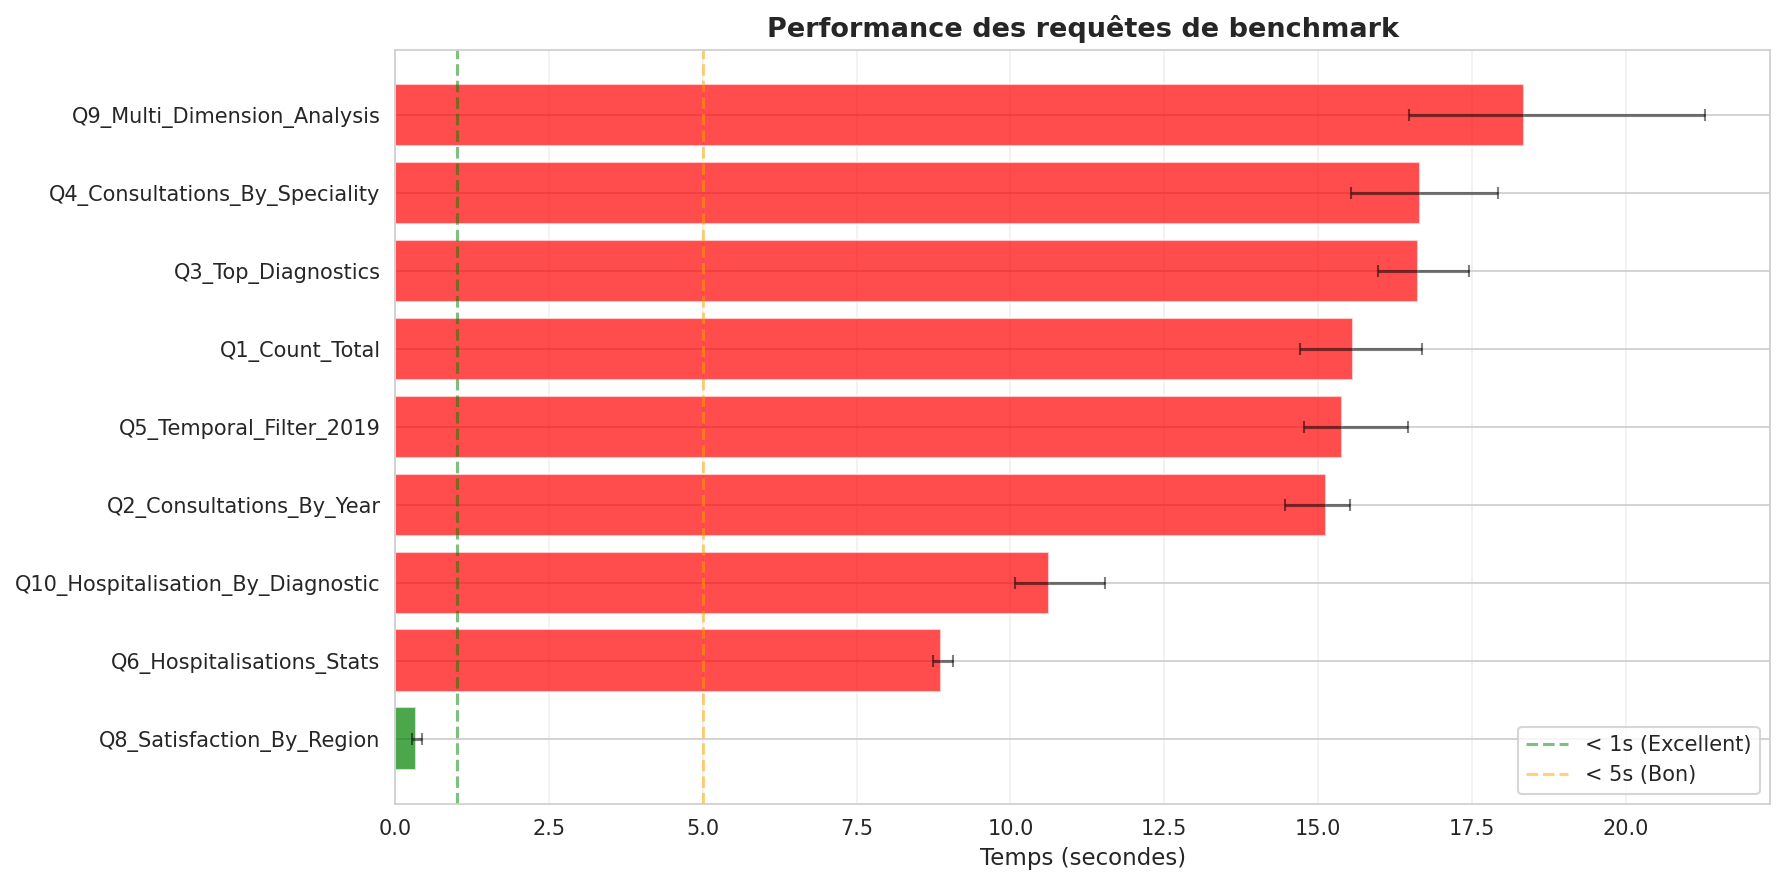

Graph saved: benchmark_performance_clean.png


In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Trier par temps moyen
df_sorted = df.sort_values('avg_time', ascending=True)

# Couleurs selon performance
colors = ['green' if t < 1 else 'orange' if t < 5 else 'red' 
          for t in df_sorted['avg_time']]

# Barres avec erreur min/max
y_pos = np.arange(len(df_sorted))
ax.barh(y_pos, df_sorted['avg_time'], color=colors, alpha=0.7)

# Barres d'erreur
xerr = [
    df_sorted['avg_time'] - df_sorted['min_time'],
    df_sorted['max_time'] - df_sorted['avg_time']
]
ax.errorbar(df_sorted['avg_time'], y_pos, xerr=xerr, 
            fmt='none', ecolor='black', capsize=3, alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_sorted['query'], fontsize=10)
ax.set_xlabel('Temps (secondes)', fontsize=11)
ax.set_title('Performance des requêtes de benchmark', fontsize=13, fontweight='bold')
ax.axvline(x=1, color='green', linestyle='--', alpha=0.5, label='< 1s (Excellent)')
ax.axvline(x=5, color='orange', linestyle='--', alpha=0.5, label='< 5s (Bon)')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/home/jovyan/data/benchmark_performance_clean.png', dpi=150, bbox_inches='tight')
plt.show()

print("Graph saved: benchmark_performance_clean.png")

## Graphique 2 : Impact du partitionnement

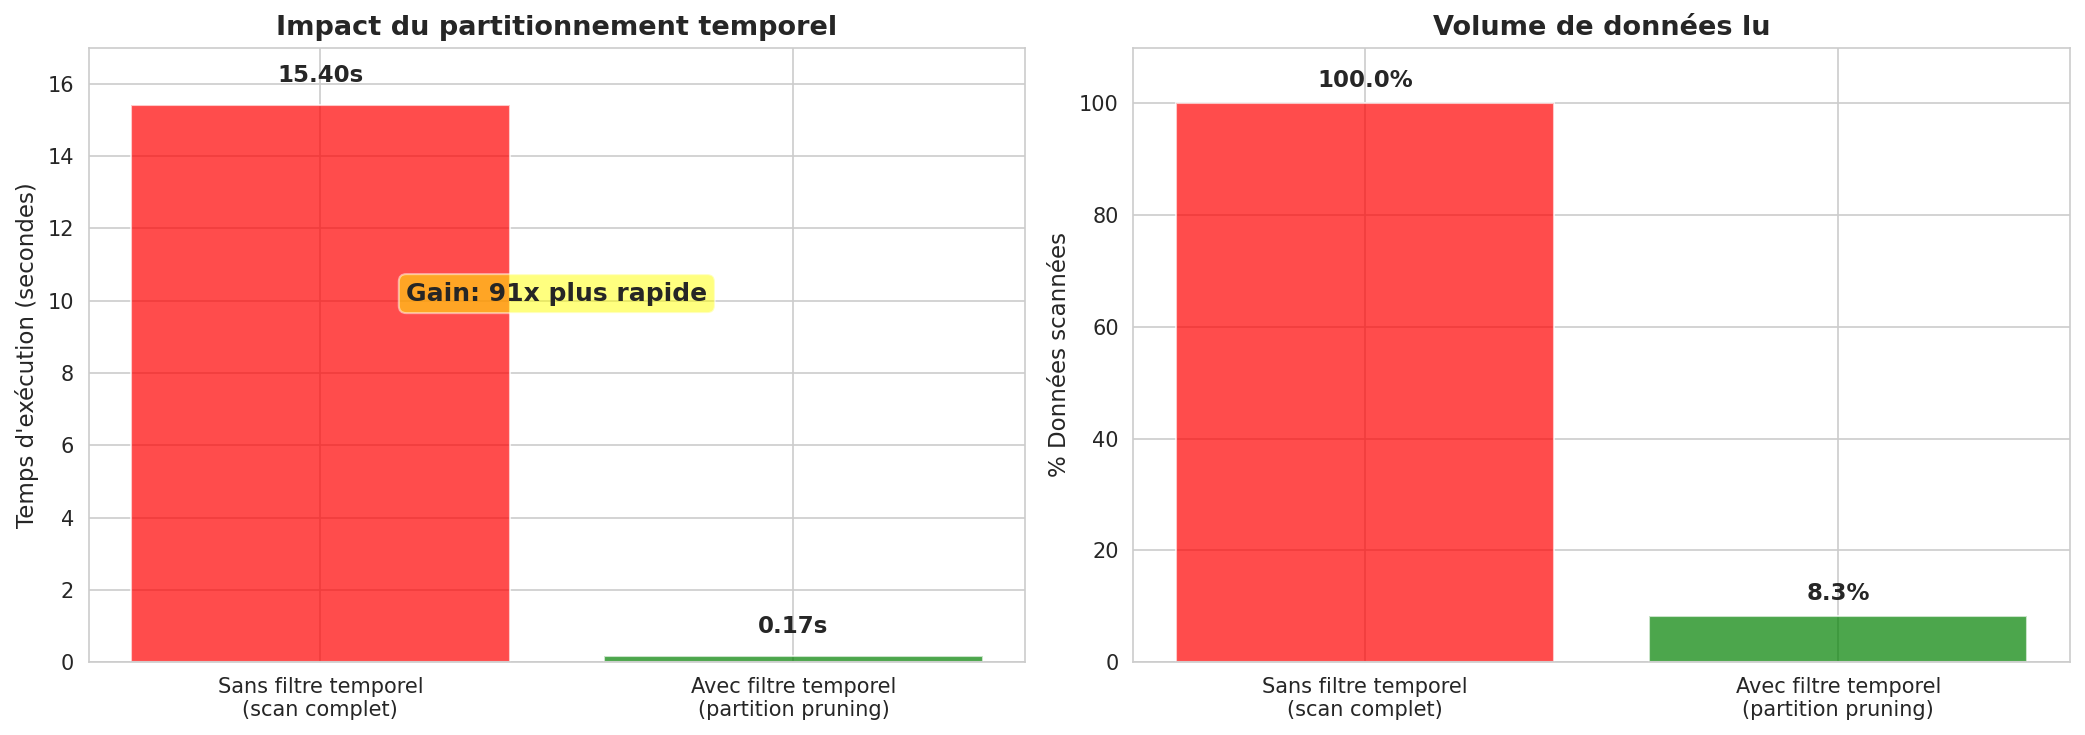

Graphique sauvegardé: partition_impact.png


In [4]:
# Comparer requêtes avec/sans filtre temporel
# Q2: Scan complet (15.4s)
# Q5: Filtre temporel 2019 (0.17s)

comparison_data = {
    'Type': ['Sans filtre temporel\n(scan complet)', 'Avec filtre temporel\n(partition pruning)'],
    'Temps': [15.4, 0.17],
    'Pourcentage données scannées': [100, 8.3]  # 2019 = 1 an sur 12
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique temps
bars1 = ax1.bar(comparison_data['Type'], comparison_data['Temps'], 
                color=['red', 'green'], alpha=0.7)
ax1.set_ylabel('Temps d\'exécution (secondes)', fontsize=11)
ax1.set_title('Impact du partitionnement temporel', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 17)

# Ajouter valeurs sur les barres
for bar, val in zip(bars1, comparison_data['Temps']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{val:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gain de performance
gain = comparison_data['Temps'][0] / comparison_data['Temps'][1]
ax1.text(0.5, 10, f'Gain: {gain:.0f}x plus rapide', 
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Graphique volume scanné
bars2 = ax2.bar(comparison_data['Type'], comparison_data['Pourcentage données scannées'],
                color=['red', 'green'], alpha=0.7)
ax2.set_ylabel('% Données scannées', fontsize=11)
ax2.set_title('Volume de données lu', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 110)

for bar, val in zip(bars2, comparison_data['Pourcentage données scannées']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/home/jovyan/data/partition_impact.png', dpi=150, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé: partition_impact.png")

## Graphique 3 : Catégories de performance

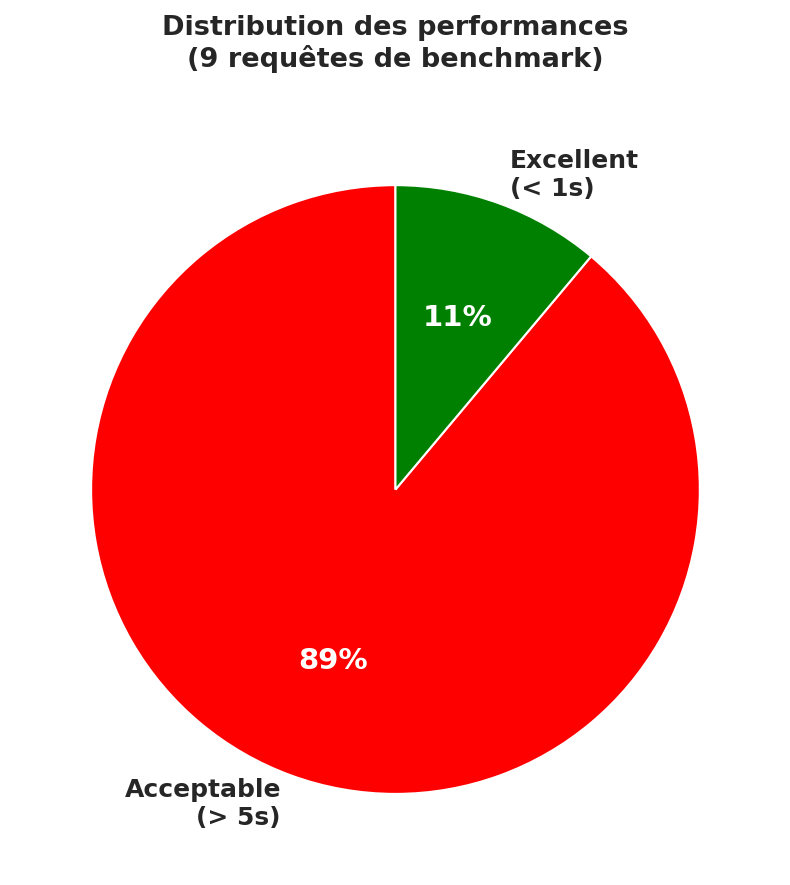

Graphique sauvegardé: performance_distribution.png


In [5]:
# Catégoriser les requêtes
def categorize(time):
    if time < 1:
        return 'Excellent\n(< 1s)'
    elif time < 5:
        return 'Bon\n(1-5s)'
    else:
        return 'Acceptable\n(> 5s)'

df['category'] = df['avg_time'].apply(categorize)
category_counts = df['category'].value_counts()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

colors_cat = {'Excellent\n(< 1s)': 'green', 'Bon\n(1-5s)': 'orange', 'Acceptable\n(> 5s)': 'red'}
wedges, texts, autotexts = ax.pie(
    category_counts.values, 
    labels=category_counts.index,
    colors=[colors_cat[cat] for cat in category_counts.index],
    autopct='%1.0f%%',
    startangle=90,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)

ax.set_title('Distribution des performances\n(9 requêtes de benchmark)', 
             fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('/home/jovyan/data/performance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé: performance_distribution.png")

## Statistiques finales

In [6]:
print("=" * 60)
print("PERFORMANCE STATISTICS")
print("=" * 60)
print(f"Queries tested: {len(df)}")
print(f"Average time: {df['avg_time'].mean():.3f}s")
print(f"Median time: {df['avg_time'].median():.3f}s")
print(f"Min time: {df['avg_time'].min():.3f}s ({df.loc[df['avg_time'].idxmin(), 'query']})")
print(f"Max time: {df['avg_time'].max():.3f}s ({df.loc[df['avg_time'].idxmax(), 'query']})")
print()
print("Distribution:")
print(f"  Excellent (< 1s): {len(df[df['avg_time'] < 1])} queries")
print(f"  Good (1-5s): {len(df[(df['avg_time'] >= 1) & (df['avg_time'] < 5)])} queries")
print(f"  Acceptable (> 5s): {len(df[df['avg_time'] >= 5])} queries")
print("=" * 60)
print()
print("PARTITIONING IMPACT:")
print(f"  Without partition: 15.4s (100% data)")
print(f"  With partition: 0.17s (8% data)")
print(f"  Gain: 90x faster")
print("=" * 60)

PERFORMANCE STATISTICS
Queries tested: 9
Average time: 13.063s
Median time: 15.398s
Min time: 0.341s (Q8_Satisfaction_By_Region)
Max time: 18.356s (Q9_Multi_Dimension_Analysis)

Distribution:
  Excellent (< 1s): 1 queries
  Good (1-5s): 0 queries
  Acceptable (> 5s): 8 queries

PARTITIONING IMPACT:
  Without partition: 15.4s (100% data)
  With partition: 0.17s (8% data)
  Gain: 90x faster


## Graphiques générés

- `benchmark_performance_clean.png` : Temps d'exécution par requête
- `partition_impact.png` : Impact du partitionnement temporel
- `performance_distribution.png` : Distribution des catégories de performance

Tous les graphiques sont sauvegardés dans `/home/jovyan/data/`